In [ ]:
!pip install pyvi
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils
import pandas as pd
import regex as re
import random as rd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 8.4 MB/s 
     |████████████████████████████████| 965 kB 58.3 MB/s 


In [ ]:
datafile = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/tiki-train.csv')

data = pd.DataFrame({'label':datafile['ratings'], 'text':datafile['discriptions']})
data = data.dropna()
data = data.reset_index(drop=True)
print('Data bình luận:\n\n', data)

Data bình luận:

         label                                               text
0           5  tiki giao hàng nhanh đóng gói cần thận nhân vi...
1           1  tôi mua nó để chơi game để không làm phiền ngư...
2           4  ổn chất lượng sẽ theo thời gian trả lời bây gi...
3           5  sản phẩm dùng tốt chất lượng đường hàn đẹp rất...
4           5  mình rất hài lòng với sản phẩm này và dịch vụ ...
...       ...                                                ...
321603      5                                          đúng loại
321604      3  giao hàng tre 1ngay hàng tốt giá rẻ cảm ơn cty...
321605      1  san pham mua ve vua mong lai co mot cai thao l...
321606      4  sách hay thật và đọc cuốn thật như những nhận ...
321607      5  dây dày dặn chắc chắn đóng gói đẹp mình ở hn đ...

[321608 rows x 2 columns]


Số lượng:  321608
Phân bố dữ liệu:  {1: 28295, 2: 14731, 3: 27463, 4: 56920, 5: 194199} 



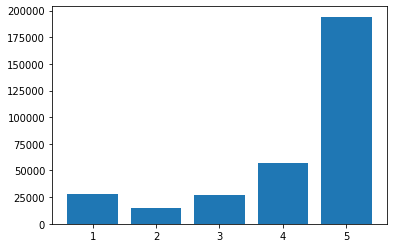

In [ ]:
print('Số lượng: ',len(data))

text = data['text'].values
label = data['label'].values

size_label = {1:0, 2:0, 3:0, 4:0, 5:0}

for x in range(0, len(label)):
  size_label[label[x]] +=1

print('Phân bố dữ liệu: ',size_label,'\n')

x=np.array([1,2,3,4,5])
y=np.array([size_label[1],size_label[2],size_label[3],size_label[4],size_label[5]])
plt.bar(x,y)
plt.show()

Số lượng:  500
Phân bố dữ liệu:  {1: 31, 2: 14, 3: 61, 4: 119, 5: 275} 



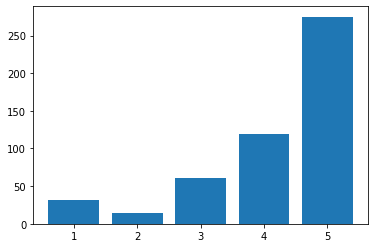

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Data/train.txt') as checkfile:
  checkdata = checkfile.read()

datac = checkdata.split('\n')
labelc = []
textc = []
for x in datac:
  labelc.append(int(x[0]))
  textc.append(x[2:])

print('Số lượng: ',len(labelc))
size_labelc = {1:0, 2:0, 3:0, 4:0, 5:0}
for x in range(0, len(labelc)):
  size_labelc[labelc[x]] +=1

print('Phân bố dữ liệu: ',size_labelc,'\n')
x=np.array([1,2,3,4,5])
y=np.array([size_labelc[1],size_labelc[2],size_labelc[3],size_labelc[4],size_labelc[5]])
plt.bar(x,y)
plt.show()

In [ ]:
with open ('/content/drive/MyDrive/Colab Notebooks/Data/teencode.txt') as tcfile:
  teencodefile = tcfile.read()

teencodedata = teencodefile.split('\n')
teencode = {}
for x in range(0,len(teencodedata)):
  tmp = teencodedata[x].split('\t')
  teencode[tmp[0]] = tmp[1]

#print('Danh sách teencode:', teencode)

with open ('/content/drive/MyDrive/Colab Notebooks/Data/dict_VN.txt') as dictfile:
  dict_vn = dictfile.read()
dict_VN = dict_vn.split('\n')
for x in range(0,len(dict_VN)):
  dict_VN[x]=dict_VN[x].lower()
dict_VN.sort()

In [ ]:
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
dicchar = loaddicchar()

# Hàm chuyển Unicode dựng sẵn về Unicde tổ hợp (phổ biến hơn)
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word
    chars = list(word)
    while(len(chars)>1):
      if(chars[-1] == chars[-2]):
        del chars[-1]
      else:
        break
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)


def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True


def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

def remove_html(txt):
    return re.sub(r'<[^>]*>', '', txt)

def text_preprocess(document):
    # xóa html code
    document = remove_html(document)
    # chuẩn hóa unicode
    document = convert_unicode(document)
    # chuẩn hóa cách gõ dấu tiếng Việt
    document = chuan_hoa_dau_cau_tieng_viet(document)
    # đưa về lower
    document = document.lower()
    # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    # teencode
    listtext = document.split()
    for x in range(0,len(listtext)):
      for y in teencode:
        if(listtext[x]==y): listtext[x]=teencode[y]
    document = ' '.join(listtext)
    return document

def search_dict(word):
  first = 0
  last = len(dict_VN)-1
  while(first <= last):
    mid = int ((first + last)/2)
#    print('word: ' + word +'    first: '+ dict_VN[first] +'    mid: '+ dict_VN[mid] +'    last: '+ dict_VN[last])
    if(dict_VN[mid]==word): 
      return True
    else: 
      if(first == last): 
        return False
    if(dict_VN[mid] < word): 
      first = mid+1
    else: 
      last = mid-1

def is_sentence_VN(sentence):
  sentence = ViTokenizer.tokenize(sentence)
  listwords = sentence.split(' ')
  for x in listwords:
    if (not x.isdigit()):
      if( not search_dict(x.replace('_',' ')) ):
        return False
  return True

In [ ]:
text_1 = []
text_2 = []
text_3 = []
text_4 = []
text_5 = []

for x in range(0,len(text)):
  tmp = text_preprocess(text[x])
  if(label[x]==1):
    text_1.append(tmp)
  elif(label[x]==2):
    text_2.append(tmp)
  elif(label[x]==3):
    text_3.append(tmp)  
  elif(label[x]==4):
    text_4.append(tmp)  
  elif(label[x]==5):
    text_5.append(tmp)

In [ ]:
import random
tmp_5 = []

for x in text_5:
  if(is_sentence_VN(x)):
    tmp_5.append(x)
  else:
    if(random.randint(0,1)==0):
      tmp_5.append(x)

Phân bố dữ liệu: 
1 sao:  28295
2 sao:  14731
3 sao:  27463
4 sao:  56920
5 sao:  127250


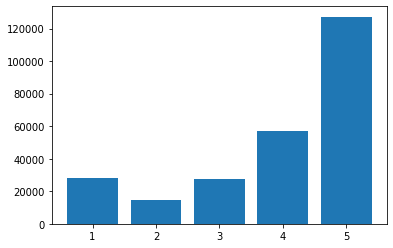

In [ ]:
print('Phân bố dữ liệu: ')
print('1 sao: ',len(text_1))
print('2 sao: ',len(text_2))
print('3 sao: ',len(text_3))
print('4 sao: ',len(text_4))
print('5 sao: ',len(tmp_5))
x=np.array([1,2,3,4,5])
y=np.array([len(text_1),len(text_2),len(text_3),len(text_4),len(tmp_5)])
plt.bar(x,y)
plt.show()

In [ ]:
import csv

with open('train_ok.csv', 'w') as f:
    writer = csv.writer(f)
    for x in text_1:
      writer.writerow([1,x])
    for x in text_2:
      writer.writerow([2,x])
    for x in text_3:
      writer.writerow([3,x])
    for x in text_4:
      writer.writerow([4,x])
    for x in tmp_5:
      writer.writerow([5,x])

Số lượng:  254572
Phân bố dữ liệu:  {1: 28294, 2: 14730, 3: 27454, 4: 56900, 5: 127194} 



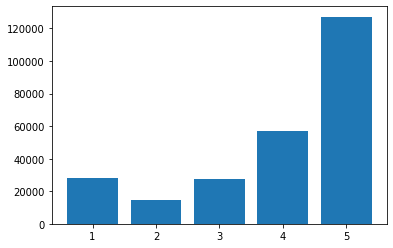

In [ ]:
datafile = pd.read_csv('/content/train_ok.csv',header=None)

data = pd.DataFrame({'label':datafile[0], 'text':datafile[1]})
data = data.dropna()
data = data.reset_index(drop=True)

print('Số lượng: ',len(data))

text = data['text'].values
label = data['label'].values

size_label = {1:0, 2:0, 3:0, 4:0, 5:0}

for x in range(0, len(label)):
  size_label[label[x]] +=1

print('Phân bố dữ liệu: ',size_label,'\n')

x=np.array([1,2,3,4,5])
y=np.array([size_label[1],size_label[2],size_label[3],size_label[4],size_label[5]])
plt.bar(x,y)
plt.show()